# The Numerai Notebook


## 1. Install dependencies and import (Imports)

In [ ]:
# Install dependencies
%%capture
!pip install pandas scikit-learn numerapi xgboost

In [ ]:
# Import packages
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from tqdm import tqdm
import pickle
import time

In [ ]:
# Import pytorch dependencies
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets

In [ ]:
# Import sklearn dependencies
from sklearn.base import BaseEstimator
from sklearn.base import RegressorMixin
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import VotingRegressor

In [ ]:
# Import miscellaneous dependencies
import numerapi as napi
from xgboost import XGBRegressor
from scipy.stats import spearmanr

## 2. Setting up Numerapi and downloading the data (Functions)



Columns: id (a randomized id that corresponds to a stock), era (a period of time), data_type (either `train`, `validation`, `test`, or `live`), feature_* (abstract financial features of the stock), target (abstract measure of stock performance).

In [ ]:
# Setup numerai api
def start_numerai(napi):
    public_id = "OBFUSCATED"
    secret_key = "OBFUSCATED"
    napi = napi.NumerAPI(public_id=public_id, secret_key=secret_key)
    all_competitions = napi.get_competitions() # get competitions
    leaderboard = napi.get_leaderboard() # get current leaderboard
    if napi.check_new_round(): # check if a new round has started
        print("new round has started within the last 24hours!")
    else:
        print("no new round within the last 24 hours")
    return napi

In [ ]:
# Download and unzip current dataset
def setup_numerai_data(napi):
    napi.download_current_dataset(unzip=True)

    # combine training data and validation data into one dataframe
    tourn_file = Path(f'./numerai_dataset_{napi.get_current_round()}/numerai_tournament_data.csv')
    train_file = Path(f'./numerai_dataset_{napi.get_current_round()}/numerai_training_data.csv')
    processed_train_file = Path('./training_processed.csv')

    if processed_train_file.exists():
        print("Loading the processed training data from file\n")
        training_data = pd.read_csv(processed_train_file)
    else:
        tourn_iter_csv = pd.read_csv(tourn_file, iterator=True, chunksize=1e6)
        val_df = pd.concat([chunk[chunk['data_type'] == 'validation'] for chunk in tqdm(tourn_iter_csv)])
        tourn_iter_csv.close()
        training_data = pd.read_csv(train_file)
        training_data = pd.concat([training_data, val_df])
        training_data.reset_index(drop=True, inplace=True)
        print("Training Dataset Generated! Saving to file ...")
        training_data.to_csv(processed_train_file, index=False)
    
    return training_data

In [ ]:
def load_tournament_data(napi):
    print("Loading tournament data ...",end=' ')
    tourn_file = Path(f'./numerai_dataset_{napi.get_current_round()}/numerai_tournament_data.csv')
    tournament_data = pd.read_csv(tourn_file)
    print("DONE")
    return tournament_data

## 3. Loading data, model learning, and the models dictionary (Functions)




In [ ]:
def load_data(training_data, idx, subset_length_mod):
    # Seperates the full training data into the specified datatype's features and targets.
    dataset = training_data.iloc[idx] # get corresponding samples
    subset_length = int(subset_length_mod*len(dataset)) # calculate length of subset
    dataset = dataset[:subset_length] # cut off data
    return dataset

In [ ]:
def load_train_data(training_data, subset_length_mod=1):
    # Seperates out train data from full training dataset.
    idx = training_data.index[training_data.data_type=='train'].tolist() # indices of training data
    dataset = load_data(training_data, idx, subset_length_mod)
    print("Loaded %i training samples out of %i (%i%%)." % (len(dataset), len(idx), int(subset_length_mod*100)))
    return dataset

In [ ]:
def load_val_data(training_data, subset_length_mod=1):
    # Seperates out validation data from full training dataset.
    idx = training_data.index[training_data.data_type=='validation'].tolist() # indices of validation data
    dataset = load_data(training_data, idx, subset_length_mod)
    print("Loaded %i validation samples out of %i (%i%%)." % (len(dataset), len(idx), int(subset_length_mod*100)))
    return dataset

In [ ]:
def split_data(dataset):
    if dataset is None:
        return None, None
    feature_cols = dataset.columns[dataset.columns.str.startswith('feature')] # feature columns names
    X = dataset[feature_cols]
    y = dataset.target
    return X, y

In [ ]:
def learn_model(model, name, train_set, val_set, save = True, replace = True, try_load=False, insta_validate=True):
    # Fits a model to the training data and adds it to the models dictionary.
    # save: saves model to a file.
    # replace: replaces all entries of this type of model when appending.

    train = True
    if try_load: # try loading model if applicable
        _model = load_model(name)
        if _model is not None:
            model = _model
            train = False
    
    if(train):
        train_X, train_y = split_data(train_set) #split train data
        start_time = time.time()
        print("Training %s ..." % name, end = ' ')
        model.fit(train_X, train_y)
        print("DONE (%.2fs)" % (time.time() - start_time))

    # save model to file (only allows one model per type)
    if save:
        save_model(model, name)

    # append model to dictionary
    if len(models) > 0:
        key_count = 0
        same_keys = []
        for key in models.keys(): # get similar keys
            if key.startswith(name):
                key_count += 1
                same_keys.append(key)
        if key_count > 0:
            if replace: # replace all similar instances
                print("Removing similar entries in RAM ...", end=' ')
                for key in same_keys:
                    del models[key]
                print("DONE (%i)" % key_count)
            else:
                name += str(key_count) # e.g. LinearRegressor3

    print("Adding model as %s to dictionary at index %i ..." % (name, len(models)), end=' ')
    models.loc[name,'Model'] = model # add model to dictionary
    print("DONE")

    if insta_validate:
        print("Validating model ...", end=' ')
        # split validation data
        val_X, val_y = split_data(val_set)
        val_mse, val_corr, val_sharpe = validate_model(model, val_set, val_X, val_y)
        models.loc[name,['MSE','Corr','Sharpe']] = (val_mse, val_corr, val_sharpe)
        print("DONE (mse=%.3f, corr=%.3f, sharpe=%.3f)" % (val_mse, val_corr, val_sharpe))

In [ ]:
def save_model(model, name):
    # Saves a model to disk.
    filename = name + '.mdl'
    filepath = 'models/' + filename
    if not Path('models/').exists():
        os.makedirs('models/')
    print("Saving model as '%s' ..." % filename, end = ' ')
    pickle.dump(model, open(filepath, 'wb'))
    print("DONE")

In [ ]:
def load_model(name):
    # Loads a model given the model name.
    filename = name + '.mdl'
    print("Loading model from file '%s' ..." % filename, end = ' ')
    filepath = 'models/' + filename
    if Path(filepath).exists():
        model = pickle.load(open(filepath, 'rb'))
        print("DONE")
        return model
    else:
        print("FAILED")
        return None

In [ ]:
def ensemble_models(model_list, weights=None, fit=False):
    # Ensembles a list of fitted or non-fitted models.
    # TODO this function withotu fitting and  with automatic naming
    for model in model_list:
        list(models.keys())[list(models.values()).index(model)]
    ensemble = VotingRegressor([('xgr',model_xgr), ('ada',model_ada), ('rfr',model_rfr)], weights= weights)
    return ensemble

In [ ]:
def print_verbose_models():
    # Prints out the models in the dictionary in a nicer way.
    names = models.index.tolist()
    estimators = models.loc[:,'Model'].tolist()
    print(names,estimators)
    if len(estimators) > 0:
        print("Models contained in the dictionary:\n")
        for i in range(0,len(estimators)):
            print('\t',names[i], ' : ', estimators[i], end = '\n\n')
    else:
        print("There are no models in the dictionary.")

## 4. Custom sklearn estimators (Classes)

In [ ]:
class MLPEstimator(BaseEstimator, RegressorMixin):
    # The sklearn estimator wrapping the pytorch neural network
    def __init__(self, torch_model, n_epochs=3, lr=0.001, momentum=0.9, batch_size=1000, verbosity=1):
        self.torch_model = torch_model
        self.n_epochs = n_epochs
        self.lr = lr
        self.momentum = momentum
        self.batch_size = batch_size
        self.verbosity = verbosity

    def fit(self, train_X, train_y=None):
        self.cuda = check_cuda()
        if(self.cuda):
            self.torch_model.cuda()

        self.criterion = nn.L1Loss()
        self.optimizer = optim.SGD(self.torch_model.parameters(), self.lr, self.momentum)

        py_train_data = NumeraiPytorchData(train_X, train_y)

        self.train_loss, self.valid_loss, self.valid_corr, self.valid_sharpe = train_model(self, self.torch_model, py_train_data, None, self.optimizer, self.criterion,
                                                       n_epochs=self.n_epochs, batchsize=self.batch_size, verbosity=self.verbosity)
        return self

    def fit2(self, train_X, train_y, val_X, val_y):
        self.cuda = check_cuda()
        if(self.cuda):
            self.torch_model.cuda()

        self.criterion = nn.L1Loss()
        self.optimizer = optim.SGD(self.torch_model.parameters(), self.lr, self.momentum)

        py_train_data = NumeraiPytorchData(train_X, train_y)
        py_val_data = NumeraiPytorchData(val_X, val_y)

        self.train_loss, self.valid_loss, self.valid_corr, self.valid_sharpe = train_model(self, self.torch_model, py_train_data, py_val_data, self.optimizer, self.criterion,
                                                       n_epochs=self.n_epochs, batchsize=self.batch_size, verbosity=self.verbosity)
        return self

    def predict(self, X):
        if(self.cuda):
            return self.torch_model(torch.tensor(X.values).cuda()).cpu().detach().numpy().squeeze()
        else:
            return self.torch_model(torch.tensor(X.values)).cpu().detach().numpy().squeeze()

    def plot_validation(self, drop_first=True):
        x = np.arange(0,self.n_epochs+1)
        
        # training loss
        sns.lineplot(x=x, y=self.train_loss)
        plt.title("loss over "+str(self.n_epochs)+" epochs")
        plt.xlim(0, len(x) - 1)
        plt.xticks(x)
        plt.xlabel("epoch")
        plt.ylabel("loss")
        
        # valid loss
        if self.valid_loss is not None:
            sns.lineplot(x=x, y=self.valid_loss, ax=axs[0])

        # corr and sharpe
        if self.valid_corr is not None:
            fig, axs = plt.subplots(1, 2,figsize=(24,6))
            axs[0].legend(['training', 'validation'], loc='upper left')
            axs[1].plot(x, self.valid_corr)
            axs[1].title.set_text("validation correlation over "+str(self.n_epochs)+" epochs")
            axs[1].set_xlabel("epoch")
            axs[1].set_ylabel("corr")
            axs[1].set(xlim=(0, len(x) - 1), xticks=x)
            axs[2].plot(x, self.valid_sharpe)
            axs[2].title.set_text("validation sharpe over "+str(self.n_epochs)+" epochs")
            axs[2].set_xlabel("epoch")
            axs[2].set_ylabel("sharpe")
            axs[2].set(xlim=(0, len(x) - 1), xticks=x)

In [ ]:
class EnsembleRegressor(BaseEstimator, RegressorMixin):
    # A custom pre-fitted ensemble regressor. Real fast.
    def __init__(self, model_names, model_mlp, weights=None, learn_weights=False):
        self.model_names = model_names
        self.model_mlp = model_mlp
        self.weights = weights
        self.learn_weights = learn_weights

    def fit(self, train_X, train_y):
        # set weights to ones if none provided
        if self.weights is None:
            self.weights = np.ones(len(self.model_names))

        if self.learn_weights:
            print("getting predictions dataset",end=' ')
            # get meta training data
            meta_X = pd.DataFrame(index=train_y.index)
            for i, name in enumerate(self.model_names):
                pred_y = pd.Series(models.loc[name,'Model'].predict(train_X),name=name)
                meta_X.loc[:,name] = pred_y
                print('.',end='')
            print(" training mlp ...",end=' ')
            self.model_mlp.fit(meta_X, train_y)
            self.weights = self.model_mlp.torch_model.w1.weight.data.numpy().squeeze()
        return self

    def predict(self, X):
        y = np.zeros(len(X))
        for i, name in enumerate(self.model_names):
            y += models.loc[name,'Model'].predict(X)*self.weights[i]
        y /= self.weights.sum()
        return y

In [ ]:
class RandomRegressor(BaseEstimator, RegressorMixin):
    # An sklearn model that just outputs uniform random numbers.
    def __init__(self):
        pass

    def fit(self, X, y):
        return self

    def predict(self, X):
        return np.random.rand(len(X))

## 5. PyTorch neural networks (Classes)



In [ ]:
class EnsembleMLP(nn.Module):
    # Pytorch neural network structure model and feed-forward
    def __init__(self):
        super(EnsembleMLP, self).__init__()
        self.w1 = nn.Linear(5, 1)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.w1(x.float())
        return x

In [ ]:
class MLP(nn.Module):
    # Pytorch neural network structure model and feed-forward
    def __init__(self):
        super(MLP, self).__init__()
        self.w1 = nn.Linear(310, 32)
        self.w2 = nn.Linear(32, 32)
        self.w3 = nn.Linear(32, 32)
        self.w4 = nn.Linear(32, 1)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = F.relu(self.w1(x.float()))
        x = F.relu(self.w2(x.float()))
        x = F.relu(self.w3(x.float()))
        x = self.w4(x)
        return x

In [ ]:
class NumeraiPytorchData(Dataset):
    # Custom pytorch dataset definition
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        features = torch.tensor(self.X.iloc[idx])
        targets = torch.tensor(self.y.iloc[idx])

        if(check_cuda()):
            return features.cuda(), targets.cuda()
        else:
            return features, targets

    def getall(self):
        features = torch.tensor(self.X.values)
        targets = torch.tensor(self.y.values)
        if(check_cuda()):
            return features.cuda(), targets.cuda()
        else:
            return features, targets

## 6. Pytorch neural networks (Functions)

In [ ]:
def check_cuda():
    # Check and use GPU/TPU if available
    if torch.cuda.is_available():
        device = torch.device("cuda")
        #print("%i cuda device available; using %s." % (torch.cuda.device_count(), torch.cuda.get_device_name(0)))
        return True
    else:
        device = torch.device("cpu")
        #print("No cuda device available.")
        return False

In [ ]:
def train_model(model, torch_model, train_set, valid_set, optimizer, criterion, n_epochs=3, batchsize=10000, shuffle_training=True, shuffle_validation=False, verbosity=1):
    # Trains the torch model and validates every step.
    print("Started training model.")
    start_time_training = time.time()

    # create data processors
    train_loader = torch.utils.data.DataLoader(train_set, batch_size = batchsize, shuffle = shuffle_training)
    train_loss, valid_loss, valid_corr, valid_sharpe = np.zeros(n_epochs+1), np.zeros(n_epochs+1), np.zeros(n_epochs+1), np.zeros(n_epochs+1)

    # compute and print initial losses and validation
    validate_epoch(model, torch_model, train_set, valid_set, train_loss, valid_loss, valid_corr, valid_sharpe, 0, n_epochs, 0, verbosity)
    
    for epoch in range(1,n_epochs+1): # for every epoch

        start_time_epoch = time.time()
        for i, (inputs, targets) in enumerate(train_loader, 0): # for every minibatch
            if verbosity > 1:
                print("minibatch %i/%i of size %i" % (i, len(train_loader), len(inputs)))

            optimizer.zero_grad() # reset the paramater gradients to 0 to prevent accumulation
            outputs = torch_model(inputs.float()) # forward pass
            loss = criterion(outputs.squeeze(), targets) # get loss
            loss.backward() # backward pass
            optimizer.step() # optimize network

        # compute and print epoch losses and validation
        validate_epoch(model, torch_model, train_set, valid_set, train_loss, valid_loss, valid_corr, valid_sharpe, epoch, n_epochs, start_time_epoch, verbosity)
            
    print("Finished training model in %.2f seconds." % (time.time() - start_time_training))

    if valid_set is None:
        return train_loss, None, None, None
    return train_loss, valid_loss, valid_corr, valid_sharpe

In [ ]:
def validate_epoch(model, torch_model, train_set, valid_set, train_loss, valid_loss, valid_corr, valid_sharpe, epoch, n_epochs, start_time_epoch, verbosity):
    # Uses different validation epoch of the overall model and torch_model to evaluate a machine learning epoch.
    compute_loss(torch_model, train_set, valid_set, train_loss, valid_loss, epoch)
    if verbosity > 0:
        string = ("Epoch %i/%i, " if epoch > 0 else "Initial Validation (epoch %i/%i), ") % (epoch, n_epochs)
        string += "Train loss: %.5f. " % (train_loss[epoch])
        if valid_set is not None:
            val_X, val_y = valid_set.getall()
            _, valid_corr[epoch], valid_sharpe[epoch] = validate_model(model, valid_set, val_X, val_y)
            string += "Validation loss: %.5f. [N] Validation correlation: %.5f. [N] Validation Sharpe: %.5f. " % (valid_loss[epoch], valid_corr[epoch], valid_sharpe[epoch])
        if epoch > 0:
            string += "(%.2fs, ETA=%is)" % (time.time() - start_time_epoch, 0)
        print(string)

In [ ]:
def compute_loss(torch_model, train_set, valid_set, train_loss, valid_loss, index):
    # Computes the MSE loss of a model's output.
    inputs, targets = train_set.getall()
    outputs = torch_model(inputs).squeeze()
    train_loss[index] = mean_squared_error(outputs.cpu().detach().numpy(), targets.cpu().numpy())
    if valid_set is not None:
        inputs, targets = valid_set.getall()
        outputs = torch_model(inputs).squeeze()
        valid_loss[index] = mean_squared_error(outputs.cpu().detach().numpy(), targets.cpu().numpy())

## 7. Validation of models (Functions)

In [ ]:
# Define validation metrics
def corr(df: pd.DataFrame) -> np.float32:
    """
    Calculate the correlation by using grouped per-era data
    :param df: A Pandas DataFrame containing the columns "era", "target" and "prediction"
    :return: The average per-era correlations.
    """
    def _score(sub_df: pd.DataFrame) -> np.float32:
        """ Calculate Spearman correlation for Pandas' apply method """
        return spearmanr(sub_df["target"],  sub_df["prediction"])[0]
    corrs = df.groupby("era").apply(_score)
    return corrs.mean() 

def sharpe(df: pd.DataFrame) -> np.float32:
    """
    Calculate the Sharpe ratio by using grouped per-era data
    :param df: A Pandas DataFrame containing the columns "era", "target" and "prediction"
    :return: The Sharpe ratio for your predictions.
    """
    def _score(sub_df: pd.DataFrame) -> np.float32:
        """ Calculate Spearman correlation for Pandas' apply method """
        return spearmanr(sub_df["target"],  sub_df["prediction"])[0]
    corrs = df.groupby("era").apply(_score)
    return corrs.mean() / corrs.std()

In [ ]:
def validate_model(model, val_set, val_X, val_y):
    # Combine validation metrics into single function
    val_preds = model.predict(val_X)
    eval_df = pd.DataFrame({'prediction':val_preds,
                            'target':val_set.target,
                            'era':val_set.era}).reset_index()
    valid_mse = mean_squared_error(val_y, val_preds, squared=False)
    valid_corr = corr(eval_df)
    valid_sharpe = sharpe(eval_df)
    return valid_mse, valid_corr, valid_sharpe

In [ ]:
def validate_models(val_set, val_X, val_y):
    # Run model validation for all models and print
    valid_mse, valid_sharpe, valid_corr = np.zeros(len(models)), np.zeros(len(models)), np.zeros(len(models))
    for i, model_name in enumerate(models):
        model = models[model_name]
        valid_mse[i], valid_corr[i], valid_sharpe[i] = validate_model(model, val_set, val_X, val_y)
        print("%s, Validation 1-MSE: %.5f. Its validation correlation: %.5f. Validation sharpe: %.5f" % (model_name, valid_mse[i], valid_corr[i], valid_sharpe[i]))
    return valid_mse, valid_corr, valid_sharpe

In [ ]:
def plot_stats(allow_neg=True, sort=True):
    # Plot validation results
    sns.set_theme(style="darkgrid")
    _models = models.sort_values('Corr')
    fig, axs = plt.subplots(1,2,figsize=(25,3))
    val_mse = _models.loc[:,'MSE'].to_numpy()
    val_corr = _models.loc[:,'Corr'].to_numpy()
    val_sharpe = _models.loc[:,'Sharpe'].to_numpy()
    if val_mse is not None:
        sns.barplot(ax=axs[0],x=(val_mse if allow_neg else val_mse.clip(min=0)), y=_models.index) # MSE
        axs[0].title.set_text('Validation RMSE')
    if val_sharpe is not None:
        sns.barplot(ax=axs[1],x=(val_sharpe if allow_neg else val_sharpe.clip(min=0)), y=_models.index) # Sharpe
        axs[1].title.set_text('Validation Sharpe')
    if val_corr is not None:
        plt.figure(figsize=(25,5))
        sns1 = sns.barplot(x=(val_corr if allow_neg else val_corr.clip(min=0)), y=_models.index) # Corr
        plt.title('Validation Correlation')
    plt.show()

## 8. Generate predictions and submit (Function)

predictions must have an `id` column and a `prediction_kazutsugi` column

In [ ]:
def submit_predictions(napi, model_id, model, tour_X, submit=False):
    # predict the target on the tournament features
    print("Using '%s' for official predictions." % str(model))
    print("Making predictions ... ",end=' ')
    pred_Y = model.predict(tour_X)
    print("DONE")

    # create proper format
    print("Formatting ... ",end=' ')
    predictions_df = tour_ids.to_frame()
    predictions_df["prediction_kazutsugi"] = pred_Y
    print(pred_Y)
    predictions_df.head()
    print("DONE")

    # upload your predictions
    if(submit):
        print("Submiting predictions ... ")
        predictions_df.to_csv("predictions.csv", index=False)
        model_id = napi.get_models()['pearlygates']
        submission_id = napi.upload_predictions("predictions.csv", model_id=model_id)
        napi.submission_status(model_id)
        print("DONE")

## Abstraction laboratory

In [ ]:
# Initialize
models = pd.DataFrame(columns=['Model','MSE','Corr','Sharpe'])
napi = start_numerai(napi)
training_data = setup_numerai_data(napi)

# Load train data
train_set = load_train_data(training_data, subset_length_mod=1)

# Load validation data
val_set = load_val_data(training_data)

2021-03-21 12:31:09,195 INFO numerapi.base_api: getting rounds...


new round has started within the last 24hours!


2021-03-21 12:31:10,763 INFO numerapi.base_api: target file already exists


Loading the processed training data from file

Loaded 501808 training samples out of 501808 (100%).
Loaded 137779 validation samples out of 137779 (100%).


In [ ]:
# Random
model_rand = RandomRegressor() 
learn_model(model_rand, 'RandomRegressor', train_set, val_set, save=False, replace=True, try_load=False)

Training RandomRegressor ... DONE (0.00s)
Adding model as RandomRegressor to dictionary at index 1 ... DONE
Validating model ... DONE (mse=0.366, corr=-0.001, sharpe=-0.061)


In [ ]:
# Linear Regression
model_lin = LinearRegression()
learn_model(model_lin, 'LinearRegression', train_set, val_set, save=True, replace=True, try_load=True)

Loading model from file 'LinearRegression.mdl' ... DONE
Saving model as 'LinearRegression.mdl' ... DONE
Adding model as LinearRegression to dictionary at index 2 ... DONE
Validating model ... DONE (mse=0.224, corr=0.016, sharpe=0.524)


In [ ]:
# Decision Tree Regressor
model_dtr = DecisionTreeRegressor(random_state=1, max_depth = 8)
learn_model(model_dtr, 'DecisionTreeRegressor_d8', train_set, val_set, save=True, replace=True, try_load=True)

Loading model from file 'DecisionTreeRegressor_d8.mdl' ... DONE
Saving model as 'DecisionTreeRegressor_d8.mdl' ... DONE
Adding model as DecisionTreeRegressor_d8 to dictionary at index 3 ... DONE
Validating model ... DONE (mse=0.224, corr=0.009, sharpe=0.665)


In [ ]:
# ADABoost
model_ada = AdaBoostRegressor(DecisionTreeRegressor(max_depth=5), n_estimators=100, random_state=1)
learn_model(model_ada, 'AdaBoostRegressor_d5n100', train_set, val_set, save=True, replace=True, try_load=True)

Loading model from file 'AdaBoostRegressor_d5n100.mdl' ... DONE
Saving model as 'AdaBoostRegressor_d5n100.mdl' ... DONE
Adding model as AdaBoostRegressor_d5n100 to dictionary at index 4 ... DONE
Validating model ... DONE (mse=0.224, corr=0.012, sharpe=0.601)


In [ ]:
# Random Forest Regressor
model_rfr = RandomForestRegressor(n_estimators = 100, max_depth = 5, max_leaf_nodes=100, random_state = 1)
learn_model(model_rfr, 'RandomForestRegressor_n100', train_set, val_set, save=True, replace=True, try_load=True)

Loading model from file 'RandomForestRegressor_n100.mdl' ... DONE
Saving model as 'RandomForestRegressor_n100.mdl' ... DONE
Adding model as RandomForestRegressor_n100 to dictionary at index 5 ... DONE
Validating model ... DONE (mse=0.223, corr=0.020, sharpe=0.723)


In [ ]:
# XGBoost
model_xgr = XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.3, learning_rate = 0.05,
                         max_depth = 8, alpha = 10, n_estimators = 20, verbosity=1)
learn_model(model_xgr, 'XGBoost_255', train_set, val_set, save=True, replace=True, try_load=True)

model_xgr = XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.3, learning_rate = 0.05,
                         max_depth = 8, alpha = 10, n_estimators = 200, verbosity=1)
learn_model(model_xgr, 'XGBoost_254', train_set, val_set, save=True, replace=True, try_load=True)

Loading model from file 'XGBoost_255.mdl' ... DONE
Saving model as 'XGBoost_255.mdl' ... DONE
Adding model as XGBoost_255 to dictionary at index 6 ... DONE
Validating model ... DONE (mse=0.223, corr=0.012, sharpe=0.451)
Loading model from file 'XGBoost_254.mdl' ... DONE
Saving model as 'XGBoost_254.mdl' ... DONE
Adding model as XGBoost_254 to dictionary at index 7 ... DONE
Validating model ... DONE (mse=0.224, corr=0.020, sharpe=0.711)


In [ ]:
# Neural Network
if False:
    model_mlp = MLPEstimator(MLP(), n_epochs=3, lr=0.005, momentum=0.9, batch_size=1000000, verbosity=1)
    learn_model(model_mlp, 'NeuralNetwork', train_set, val_set, save=True, replace=True, try_load=True)
    model_mlp.plot_validation(drop_first=False)

In [ ]:
# Ensembles
ensemble = EnsembleRegressor(['XGBoost_254', 'AdaBoostRegressor_d5n100', 'RandomForestRegressor_n100'], None, learn_weights=False)
learn_model(ensemble, 'Ensemble_(XGR,ADA,RFR)', None, val_set, save=True, replace=True, try_load=False)

ensemble = EnsembleRegressor(['XGBoost_254', 'LinearRegression', 'RandomForestRegressor_n100'], None, learn_weights=False)
learn_model(ensemble, 'Ensemble_(XGR,LIN,RFR)', None, val_set, save=True, replace=True, try_load=False)

ensemble = EnsembleRegressor(['XGBoost_254', 'AdaBoostRegressor_d5n100', 'LinearRegression', 'RandomForestRegressor_n100'], None, weights=np.array([0.7,0.4,1,1]), learn_weights=False)
learn_model(ensemble, 'Ensemble_(XGR,ADA,LIN,RFR)', None, val_set, save=True, replace=True, try_load=False)

ensemble = EnsembleRegressor(['LinearRegression', 'XGBoost_254', 'AdaBoostRegressor_d5n100', 'RandomForestRegressor_n100', 'DecisionTreeRegressor_d8'], None, learn_weights=False)
learn_model(ensemble, 'Ensemble_META_Raw', None, val_set, save=True, replace=True, try_load=False)

Training Ensemble_(XGR,ADA,RFR) ... DONE (0.00s)
Saving model as 'Ensemble_(XGR,ADA,RFR).mdl' ... DONE
Adding model as Ensemble_(XGR,ADA,RFR) to dictionary at index 7 ... DONE
Validating model ... DONE (mse=0.223, corr=0.022, sharpe=0.756)
Training Ensemble_(XGR,LIN,RFR) ... DONE (0.00s)
Saving model as 'Ensemble_(XGR,LIN,RFR).mdl' ... DONE
Adding model as Ensemble_(XGR,LIN,RFR) to dictionary at index 8 ... DONE
Validating model ... DONE (mse=0.223, corr=0.022, sharpe=0.700)
Training Ensemble_(XGR,ADA,LIN,RFR) ... DONE (0.00s)
Saving model as 'Ensemble_(XGR,ADA,LIN,RFR).mdl' ... DONE
Adding model as Ensemble_(XGR,ADA,LIN,RFR) to dictionary at index 9 ... DONE
Validating model ... DONE (mse=0.223, corr=0.022, sharpe=0.694)
Training Ensemble_META_Raw ... DONE (0.00s)
Saving model as 'Ensemble_META_Raw.mdl' ... DONE
Adding model as Ensemble_META_Raw to dictionary at index 10 ... DONE
Validating model ... DONE (mse=0.223, corr=0.022, sharpe=0.816)


In [ ]:
ensemble_mlp = MLPEstimator(EnsembleMLP(), n_epochs=5, lr=0.010, momentum=0.9, batch_size=110000, verbosity=1)
ensemble = EnsembleRegressor(['LinearRegression', 'XGBoost_254', 'AdaBoostRegressor_d5n100', 'RandomForestRegressor_n100', 'DecisionTreeRegressor_d8'], ensemble_mlp, learn_weights=True)
#learn_model(ensemble, 'Ensemble_META_fit', train_set, val_set, save=True, replace=True, try_load=False)

In [ ]:
#ensemble_mlp.plot_validation()

In [ ]:
# Checkout super cool DataFrame
#print_verbose_models() # use this for way too much info
models.head()

,Model,MSE,Corr,Sharpe
RandomRegressor,RandomRegressor(),0.36513,0.000472428,0.0370433
LinearRegression,"LinearRegression(copy_X=True, fit_intercept=Tr...",0.223614,0.0162465,0.523684
DecisionTreeRegressor_d8,"DecisionTreeRegressor(ccp_alpha=0.0, criterion...",0.224209,0.00904539,0.665165
AdaBoostRegressor_d5n100,"(DecisionTreeRegressor(ccp_alpha=0.0, criterio...",0.223504,0.0121595,0.600555
RandomForestRegressor_n100,"(DecisionTreeRegressor(ccp_alpha=0.0, criterio...",0.223438,0.0204683,0.723355


In [ ]:
# Delete train data
if 'train_set' in locals() or 'train_set' in globals():
    del train_set
    print("Deleted training data.")

# Delete validation data
if 'val_set' in locals() or 'val_set' in globals():
    del val_set
    print("Deleted validation data.")

Deleted training data.
Deleted validation data.


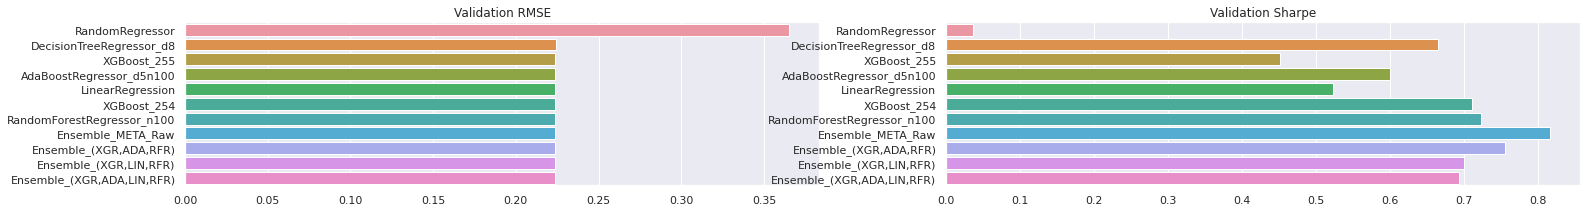

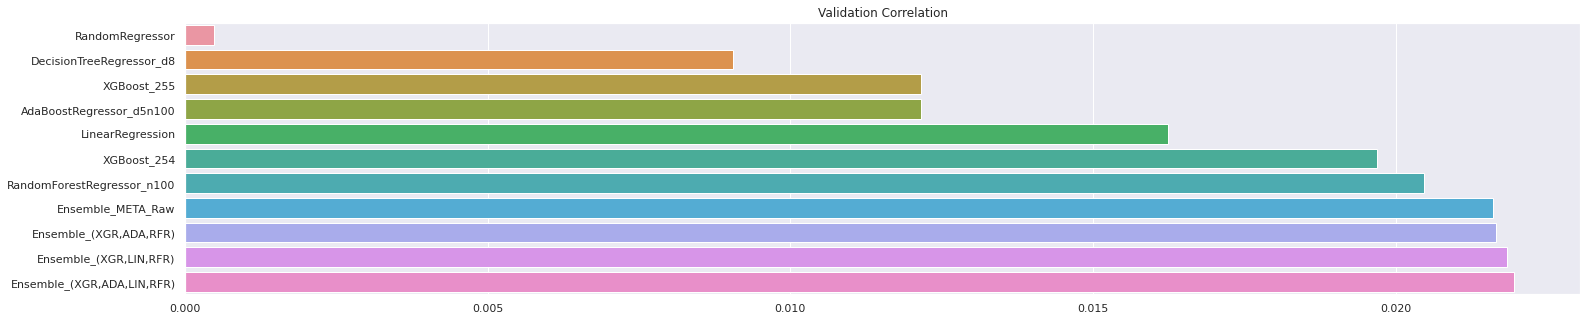

In [ ]:
# Plot model stats
plot_stats(allow_neg=False)

In [ ]:
ensemble = EnsembleRegressor(['XGBoost_254', 'AdaBoostRegressor_d5n100', 'LinearRegression', 'RandomForestRegressor_n100'], None, weights=np.array([0.7,0.4,1,1]), learn_weights=False)
learn_model(ensemble, 'Ensemble_(XGR,ADA,LIN,RFR)', None, val_set, save=True, replace=True, try_load=True)

Loading model from file 'Ensemble_(XGR,ADA,LIN,RFR).mdl' ... DONE
Saving model as 'Ensemble_(XGR,ADA,LIN,RFR).mdl' ... DONE
Adding model as Ensemble_(XGR,ADA,LIN,RFR) to dictionary at index 8 ... DONE
Validating model ... DONE (mse=0.223, corr=0.022, sharpe=0.694)


In [ ]:
# Load tournament data
tournament_data = load_tournament_data(napi)
tour_X, tour_y = split_data(tournament_data)
del tournament_data, tour_y

Loading tournament data ... DONE


In [ ]:
# Specify models
model_id = napi.get_models()['pearlygates']
model = models.loc['Ensemble_(XGR,ADA,LIN,RFR)','Model']

In [ ]:
# Submit predictions to Numerai
submit_predictions(napi, model_id, model, tour_X, submit=False)

Using 'EnsembleRegressor(learn_weights=False, model_mlp=None,
                  model_names=['XGBoost_254', 'AdaBoostRegressor_d5n100',
                               'LinearRegression',
                               'RandomForestRegressor_n100'],
                  weights=array([0.7, 0.4, 1. , 1. ]))' for official predictions.
Making predictions ...  

NameError: ignored

In [ ]:
### TODO LIST
# TODO: Create a meta-method to run through ensemble weights and find the best possible ensemble and its weights
# TODO: Creat pandas dataframe of stats and sort to create nicer graph.

# Done 🚀

Head back over to https://numer.ai/submit to continue.